# TopoCluster Regression

This is a simple, stripped-down notebook for training networks. I've removed most of the models that are present in `TopoClusterRegressionRewrite.ipynb`, as well as most of the plots (I find that the multitude of plots makes things a bit cumbersome and hard to navigate -- I'll see if I can change the way they are displayed later on).

Here, we just train the so-called `all` model, which uses images from all $6$ calo layers. We train two versions, for charged and neutral pions.

#### 1) Initial setup

In [1]:
path_prefix = '/workspace/LCStudies/'

In [2]:
# Check if latex is set up already.
# We use some Jupyter magic -- alternatively one could use python's subprocess here.
has_latex = !command -v latex
has_latex = (not has_latex == [])

# If latex was not a recognized command, our setup script should have installed
# at a fixed location, but it is not on the $PATH. Now let's use some Jupyter magic.
# See https://ipython.readthedocs.io/en/stable/interactive/shell.html for info.
if(not has_latex):
    latex_prefix = '/usr/local/texlive/2020/bin/x86_64-linux'
    jupyter_env = %env
    path = jupyter_env['PATH']
    path = path + ':' + latex_prefix
    %env PATH = $path
    jupyter_env = %env
    path = jupyter_env['PATH']

env: PATH=/opt/conda/envs/ml4p/bin:/opt/conda/condabin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/texlive/2020/bin/x86_64-linux


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# ML fitting/loading/saving settings
loadModel = False # if false, then run trainings directly. otherwise load the file.
saveModel = True # if true, save the current model to disk.
from tensorflow.keras.models import load_model

In [5]:
# Import some basic libraries.
import sys, os
import numpy as np
import pandas as pd # we will use some uproot/pandas interplay here.
import uproot as ur

# Import our resolution utilities
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu
from  util import qol_util as qu # for progress bar

plotpath = path_prefix + 'regression/Plots/'
modelpath_c = path_prefix +  'classifier/Models/'
modelpath = path_prefix + 'regression/Models/'
paths = [plotpath, modelpath_c, modelpath]
for path in paths:
    try: os.makedirs(plotpath)
    except: pass

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

#### 2) Get the training data.

In [6]:
data_dir = path_prefix + 'data/pion/'
data_filenames = {'pp':data_dir+'piplus.root','pm':data_dir+'piminus.root','p0':data_dir+'pi0.root'}
data_files = {key:ur.open(val) for key,val in data_filenames.items()}
tree_name = 'ClusterTree'
data_trees = {key:val[tree_name] for key, val in data_files.items()}
branches = ['truthE', 'clusterE', 'clusterEta', 'cluster_ENG_CALIB_TOT']
#branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
data_frames = {key:val.pandas.df(branches,flatten=False) for key,val in data_trees.items()}

print("Number of pi+ events: {}".format(len(data_frames['pp'])))
print("Number of pi- events: {}".format(len(data_frames['pm'])))
print("Number of pi0 events: {}".format(len(data_frames['p0'])))

Number of pi+ events: 435967
Number of pi- events: 434627
Number of pi0 events: 263891


In [7]:
from sklearn.preprocessing import StandardScaler

# some regression vars (TODO: Are these actually being used?)
for key,frame in data_frames.items():
    frame['logE'] = np.log(frame['clusterE'])
    frame['logECalib'] = np.log(frame['cluster_ENG_CALIB_TOT'])

# create scaler
scaler_e = StandardScaler()
scaler_cal = StandardScaler()
#scaler_calAll = StandardScaler()
scaler_eta = StandardScaler()

# fit and transform in one step
for key, frame in data_frames.items():
    frame['s_logE'] = scaler_e.fit_transform(frame['logE'].to_numpy().reshape(-1,1))
    frame['s_logECalib'] = scaler_cal.fit_transform(frame['logECalib'].to_numpy().reshape(-1,1))
    frame['s_eta'] = scaler_eta.fit_transform(frame['clusterEta'].to_numpy().reshape(-1,1))

In [8]:
# Prepare the calo images for input to training.
l = len(layers) * len(data_trees.keys())
i = 0
qu.printProgressBarColor(i, l, prefix='Loading calo images:', suffix='Complete', length=50)

calo_images = {}
for key in data_trees.keys():
    calo_images[key] = {}
    
    for layer in layers:
        calo_images[key][layer] = mu.setupCells(data_trees[key],layer)
        i += 1
        qu.printProgressBarColor(i, l, prefix='Loading calo images:', suffix='Complete', length=50)

Loading calo images: |██████████████████████████████████████████████████| 100.0% Complete


In [9]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable some of the tensorflow info printouts, only display errors

import tensorflow as tf

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


To finish training data preparation, we concatenate the calorimeter images, and then combine them with columns `s_logE` and `s_Eta`.

Note that this process is a little memory-inefficient -- we're making copies of things in memory -- and I'm finding that my JupyterLab with 12Gi is running out of memory and the kernel restarts (whether or not all the memory is being used by JupyterLab is another issue...)

We can try to remedy this by deleting some stuff as soon as it's no longer needed.

In [11]:
# Concatenate images, and prepare our combined input.
All_input = {}

keys = list(calo_images.keys())
l = 3 * len(keys)
i = 0
pfx = 'Preparing combined input:'
sfx = 'Complete'
bl = 50

qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

for key in keys:
    combined_images = np.concatenate(tuple([calo_images[key][layer] for layer in layers]), axis=1)
    del calo_images[key] # delete this element of calo_images, it has been copied
    i = i + 1
    qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

    s_combined,scaler_combined = mu.standardCells(combined_images, layers)
    i = i + 1
    qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

    All_input[key] = np.column_stack((data_frames[key]['s_logE'], data_frames[key]['s_eta'],s_combined))
    i = i + 1
    qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

Preparing combined input: |██████████████████████████████████████████████████| 100.0% Complete


Now we should merge the $\pi^+$ and $\pi^-$ info, so that we have a dataset for charged pions and a dataset for neutral pions.

We will have the combined charged-pion data saved under the `pp` key, and the neutral pions under the `p0` key. The `pm` key will be deleted.

**Note** For debugging, I've currently commented out the combining of $\pi^+$ and $\pi^-$, and we're just throwing out the $\pi^-$ data completely. So for now we're just training one regression on $\pi^+$, and another on $\pi^0$ (and testing on the respective data -- note that we train on *all* events so our test can be affected by over-training but we're not worrying about that for now).

In [12]:
# combining dataframes
#data_frames['pp'] = data_frames['pp'].append(data_frames['pm'])
del data_frames['pm']

# combining our "All_input"
#All_input['pp'] = np.row_stack((All_input['pp'],All_input['pm']))
del All_input['pm']
key_conversion = {'pp':'charged pion','p0':'neutral pion'}

# Print out the number of entries in each category
for key in All_input.keys():
    print('Number of {type} events: {val}'.format(type=key_conversion[key], val = All_input[key].shape[0]))

Number of charged pion events: 435967
Number of neutral pion events: 263891


Note that we have many more charged pions than neutral pions, so this *may* result in our charged pion regression being better-trained (unless the stats for both are sufficiently high).

## Training "all" model

In [13]:
def baseline_nn_All_model():
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels + 2
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    return model

In [14]:
# Print some summary info for this model
print(baseline_nn_All_model().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 938)               880782    
_________________________________________________________________
dense_1 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_2 (Dense)              (None, 469)               440391    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 470       
Total params: 2,202,425
Trainable params: 2,202,425
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# Define our regressors (actual networks) that we will fit (train).
batch_size = 200 * ngpu
epochs = 15 # 100
verbose = 1
regressors = {key: KerasRegressor(build_fn=baseline_nn_All_model, batch_size=batch_size, epochs=epochs, verbose=verbose) for key in All_input.keys()}

In [16]:
# Train the models and save them, or load them from files.
model_file_names = {'pp':modelpath + 'all_charged.h5','p0':modelpath + 'all_neutral.h5'}
assert (set(model_file_names.keys()) == set(All_input.keys()))
histories = {}

for key, filename in model_file_names.items():
    if not loadModel:
        histories[key] = regressors[key].fit(All_input[key], data_frames[key]['s_logECalib'])
    else: 
        regressors[key].model = load_model(model_file_names[key])

    if saveModel:
        regressors[key].model.save(model_file_names[key])

Epoch 1/15
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/tas

We can evaluate the networks on our data to see how they've done.

In [17]:
for key, frame in data_frames.items():
    frame['clusterE_pred'] = np.exp(scaler_cal.inverse_transform(regressors[key].predict(All_input[key])))
    frame['clusterE_pred / cluster_ENG_CALIB_TOT'] = frame['clusterE_pred'] / frame['cluster_ENG_CALIB_TOT']

1090/1090 [==============================] - 11s 10ms/step


<ipython-input-17-72b08b5224e1>:2: RuntimeWarning: overflow encountered in exp
  frame['clusterE_pred'] = np.exp(scaler_cal.inverse_transform(regressors[key].predict(All_input[key])))


660/660 [==============================] - 9s 14ms/step


## Plotting results (testing how well our network works)

As noted above, over-training can be an issue because we've used *all* our data as our training sample. So results that are very good might not be a fully honest assessment of how we're doing -- but results that are bad are a clear sign that something is not working, because that means the network isn't performing well on the very same data used to train it.

In [18]:
import ROOT as rt

Welcome to JupyROOT 6.22/02


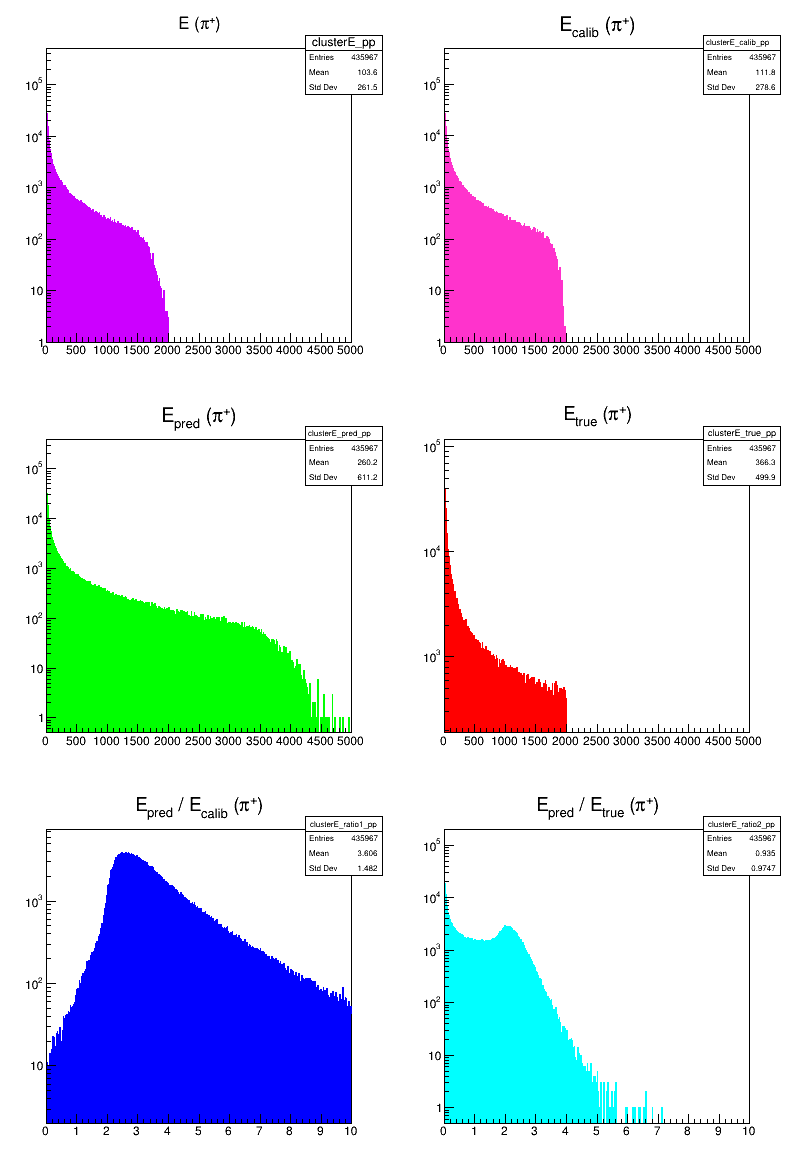

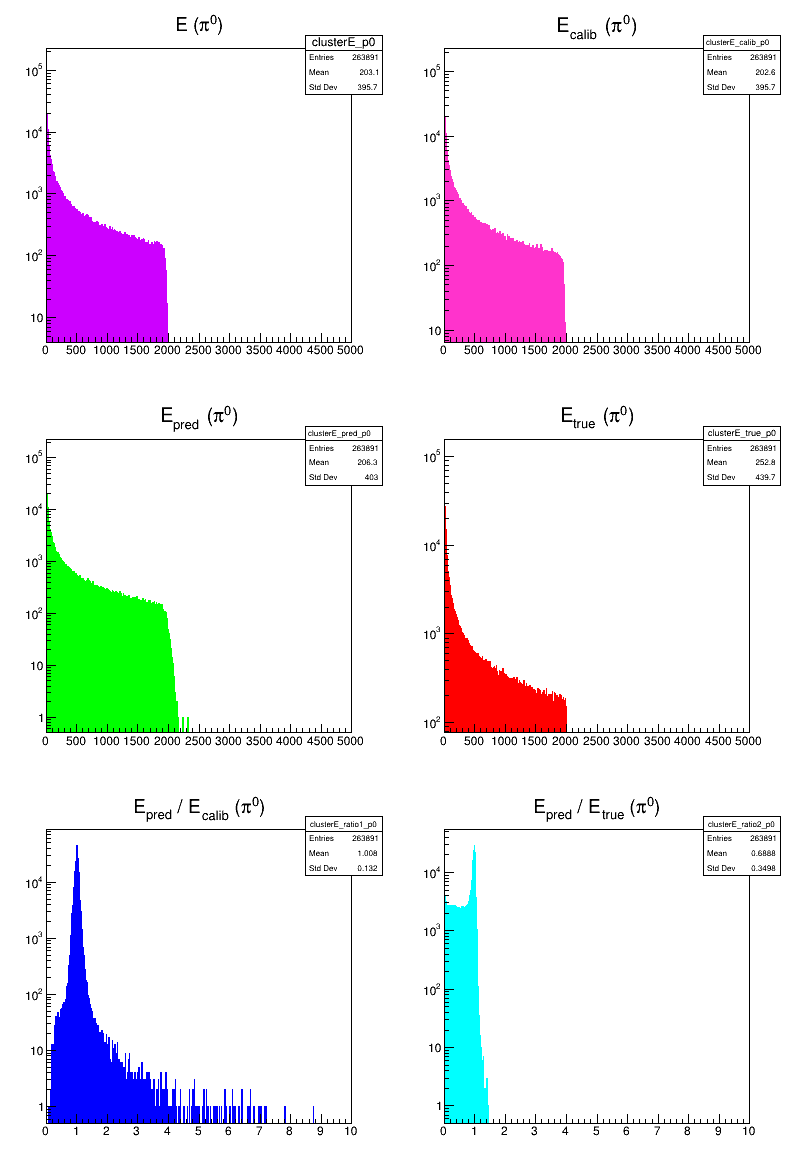

In [29]:
def SetColor(hist, color):
    hist.SetFillColor(color)
    hist.SetLineColor(color)
    return

clusterE = {}
clusterE_calib = {}
clusterE_pred = {}
clusterE_true = {}
clusterE_ratio1 = {} # ratio of predicted cluster E to calibrated cluster E
clusterE_ratio2 = {} # ratio of predicted cluster E to truth cluster E
canvs = {}

key_conversions = {'pp':'(#pi^{+})','p0':'(#pi^{0})'}

for key in data_frames.keys():
    
    clusterE[key] = rt.TH1F('clusterE_' + str(key), 'E ' + key_conversions[key], 500,0.,5000.)
    clusterE_calib[key] = rt.TH1F('clusterE_calib_' + str(key), 'E_{calib} ' + key_conversions[key], 500,0.,5000.)
    clusterE_pred[key] = rt.TH1F('clusterE_pred_' + str(key), 'E_{pred} ' + key_conversions[key], 500,0.,5000.)
    clusterE_true[key] = rt.TH1F('clusterE_true_' + str(key), 'E_{true} ' + key_conversions[key], 500,0.,5000.)
    clusterE_ratio1[key] = rt.TH1F('clusterE_ratio1_' + str(key), 'E_{pred} / E_{calib} ' + key_conversions[key], 500,0.,10.)
    clusterE_ratio2[key] = rt.TH1F('clusterE_ratio2_' + str(key), 'E_{pred} / E_{true} ' + key_conversions[key], 500,0.,10.)

    SetColor(clusterE[key], rt.kViolet)
    SetColor(clusterE_calib[key], rt.kPink + 9)
    SetColor(clusterE_pred[key], rt.kGreen)
    SetColor(clusterE_true[key], rt.kRed)
    SetColor(clusterE_ratio1[key], rt.kBlue)
    SetColor(clusterE_ratio2[key], rt.kCyan)

    meas   = data_frames[key]['clusterE'].to_numpy()
    calib  = data_frames[key]['cluster_ENG_CALIB_TOT'].to_numpy()
    pred   = data_frames[key]['clusterE_pred'].to_numpy()
    true   = data_frames[key]['truthE'].to_numpy()
    ratio1 = data_frames[key]['clusterE_pred / cluster_ENG_CALIB_TOT'].to_numpy()
    ratio2 = data_frames[key]['clusterE_pred'].to_numpy() /  data_frames[key]['truthE'].to_numpy()
    
    for i in range(len(meas)):
        clusterE[key].Fill(meas[i])
        clusterE_calib[key].Fill(calib[i])
        clusterE_pred[key].Fill(pred[i])
        clusterE_true[key].Fill(true[i])
        clusterE_ratio1[key].Fill(ratio1[i])
        clusterE_ratio2[key].Fill(ratio2[i])

    canvs[key] = rt.TCanvas('c_'+str(key),'c_'+str(key),800,1200)
    canvs[key].Divide(2,3)
    
    canvs[key].cd(1)
    clusterE[key].Draw('HIST')
    rt.gPad.SetLogy()
    
    canvs[key].cd(2)
    clusterE_calib[key].Draw('HIST')
    rt.gPad.SetLogy()


    canvs[key].cd(3)
    clusterE_pred[key].Draw('HIST')
    rt.gPad.SetLogy()
    
    canvs[key].cd(4)
    clusterE_true[key].Draw('HIST')
    rt.gPad.SetLogy()

    canvs[key].cd(5)
    clusterE_ratio1[key].Draw('HIST')
    rt.gPad.SetLogy()

    canvs[key].cd(6)
    clusterE_ratio2[key].Draw('HIST')
    rt.gPad.SetLogy()

    canvs[key].Draw()

I think that we want the ratio plots (cyan, bottom right) to be spiked around $1$. It corresponds to $\frac{E_\text{predicted}}{E_\text{true}}$. The bottom left plot (dark blue) corresponds to $\frac{E_\text{cluster, predicted}}{\text{ENG_CALIB_TOT}_\text{cluster}}$.

If the goal is to have the cyan plot spike aorund $1$, neither network is doing great but $\pi^0$ is outperforming $\pi^+$. If the goal is to have the dark blue plot spike around $1$ -- which based on the pre-existing code, might be the case? -- then $\pi^0$ is working *excellently* but $\pi^+$ is not. And I thought that they both looked good in the original training notebook (together with the plotting code that doesn't work for me quite yet). Why is this?